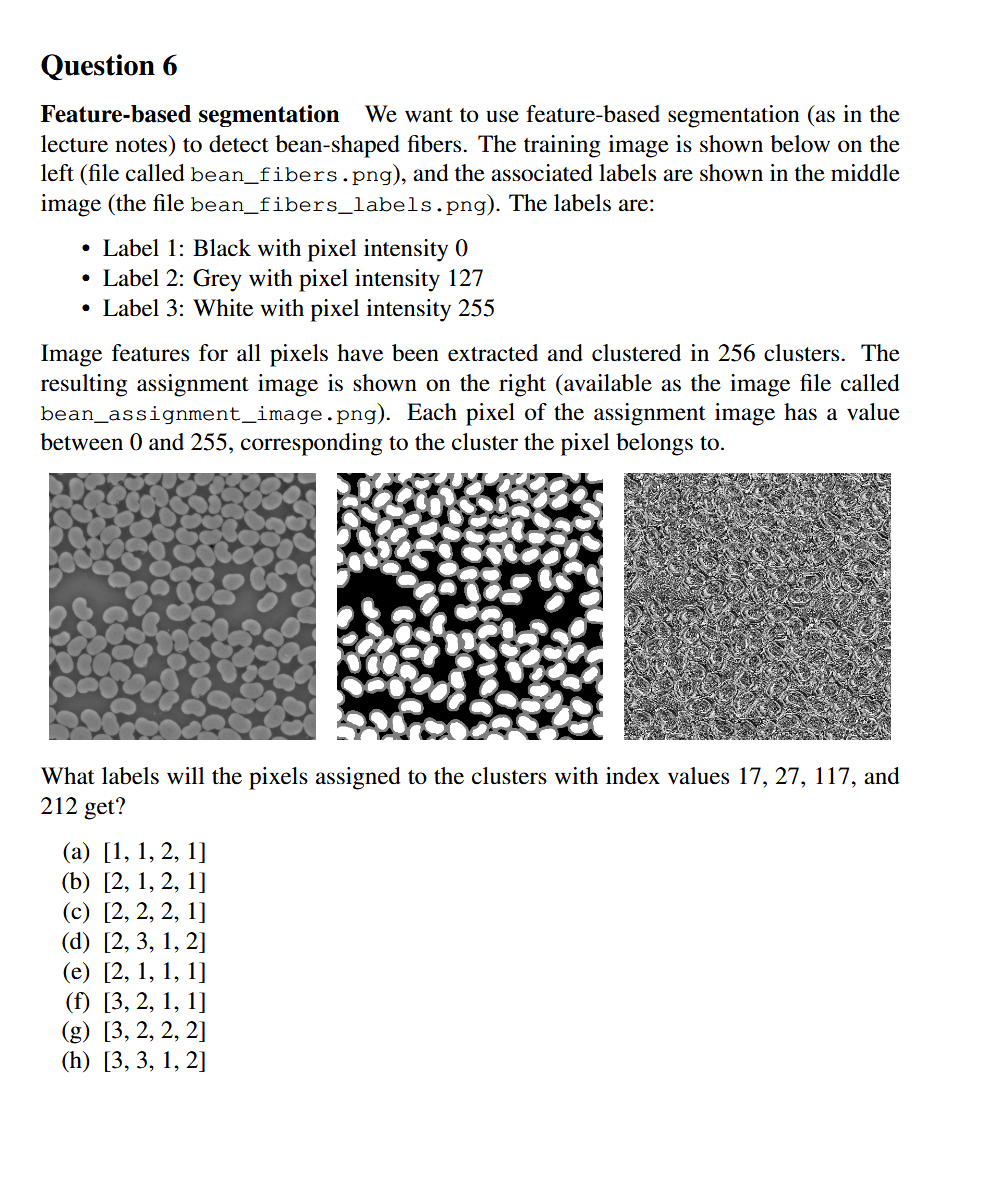

In [ ]:
import os
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster
import local_features as lf
import scipy.ndimage


In [34]:
path = 'data/bean'

im = skimage.io.imread(os.path.join(path, 'bean_fibers.png'))
label_im = skimage.io.imread(os.path.join(path, 'bean_fibers_labels.png'))
assignment_im = skimage.io.imread(os.path.join(path, 'bean_assignment_image.png'))


In [35]:
def get_cluster_label_simple(cluster_id, assignment_image, label_image):
    """Most intuitive approach - just count manually"""
    
    print(f"\nAnalyzing cluster {cluster_id}:")
    
    # Step 1: Create a mask for this cluster
    cluster_mask = (assignment_image == cluster_id)
    print(f"  - Found {cluster_mask.sum()} pixels assigned to this cluster")
    
    # Step 2: Get the labels for pixels in this cluster
    labels_in_cluster = label_image[cluster_mask]
    print(f"  - These pixels have labels: {np.unique(labels_in_cluster)}")
    
    # Step 3: Count each label type
    count_black = (labels_in_cluster == 0).sum()      # Label 1 (black)
    count_grey = (labels_in_cluster == 127).sum()     # Label 2 (grey)  
    count_white = (labels_in_cluster == 255).sum()    # Label 3 (white)
    
    print(f"  - Black pixels (0): {count_black}")
    print(f"  - Grey pixels (127): {count_grey}")
    print(f"  - White pixels (255): {count_white}")
    
    # Step 4: Decide which label wins
    counts = [count_black, count_grey, count_white]
    winner_index = counts.index(max(counts))
    winner_label = winner_index + 1  # Convert to 1, 2, 3
    
    print(f"  - Winner: Label {winner_label}")
    return winner_label

# Solve the question
clusters_to_check = [17, 27, 117, 212]
answer = []

for cluster in clusters_to_check:
    label = get_cluster_label_simple(cluster, assignment_im, label_im)
    answer.append(label)

print(f"\nFinal Answer: {answer}")


Analyzing cluster 17:
  - Found 880 pixels assigned to this cluster
  - These pixels have labels: [127 255]
  - Black pixels (0): 0
  - Grey pixels (127): 840
  - White pixels (255): 40
  - Winner: Label 2

Analyzing cluster 27:
  - Found 462 pixels assigned to this cluster
  - These pixels have labels: [127 255]
  - Black pixels (0): 0
  - Grey pixels (127): 61
  - White pixels (255): 401
  - Winner: Label 3

Analyzing cluster 117:
  - Found 1078 pixels assigned to this cluster
  - These pixels have labels: [0]
  - Black pixels (0): 1078
  - Grey pixels (127): 0
  - White pixels (255): 0
  - Winner: Label 1

Analyzing cluster 212:
  - Found 298 pixels assigned to this cluster
  - These pixels have labels: [  0 127]
  - Black pixels (0): 90
  - Grey pixels (127): 208
  - White pixels (255): 0
  - Winner: Label 2

Final Answer: [2, 3, 1, 2]


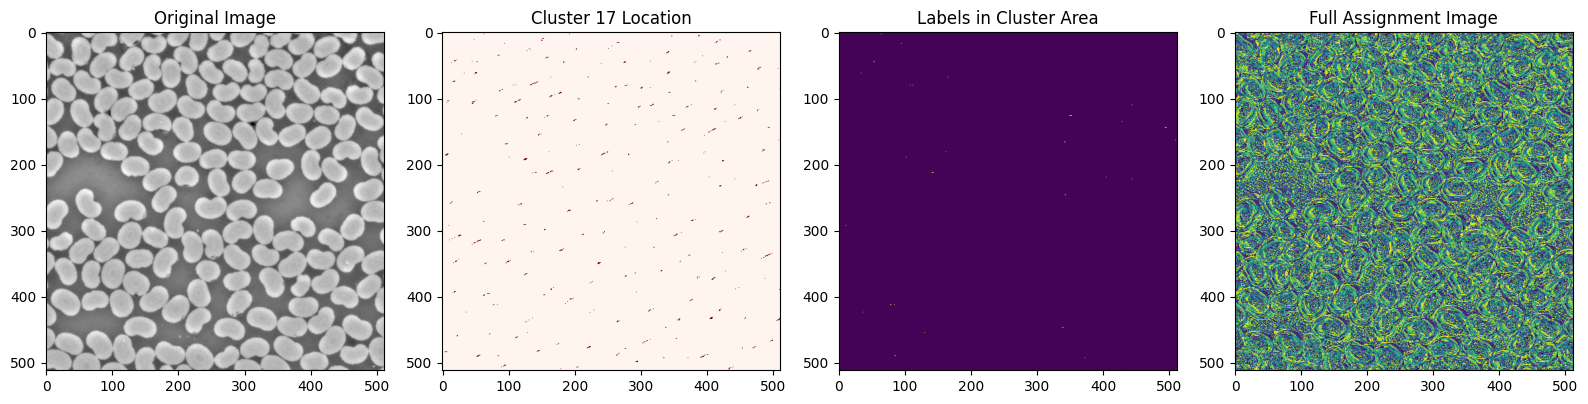

Cluster 17 contains:
  - 0 pixels with label 0 (0.0%)
  - 840 pixels with label 127 (95.5%)
  - 40 pixels with label 255 (4.5%)
  → Cluster 17 gets Label 2


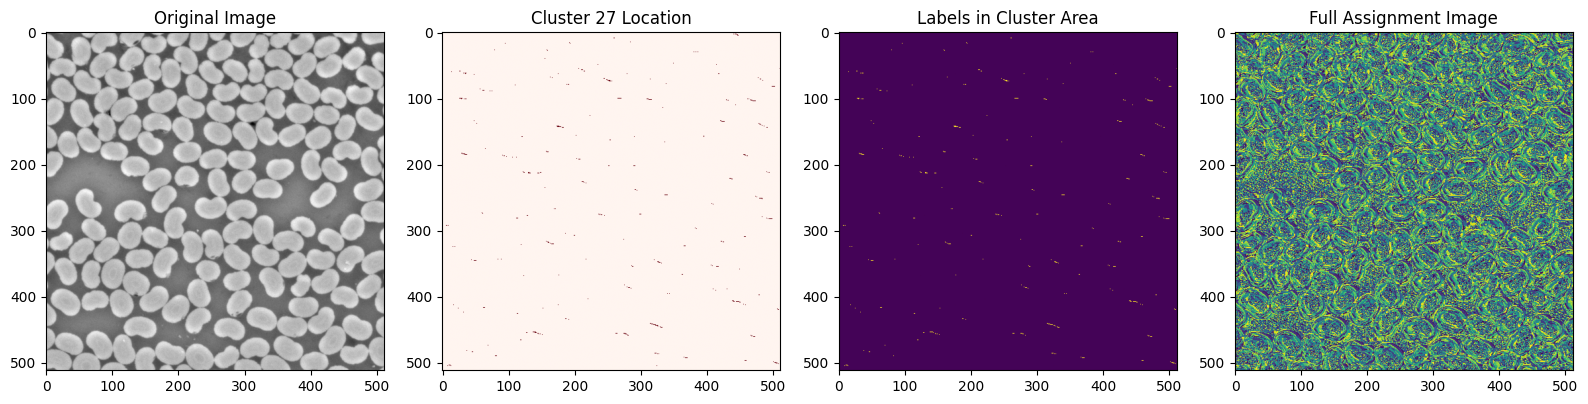

Cluster 27 contains:
  - 0 pixels with label 0 (0.0%)
  - 61 pixels with label 127 (13.2%)
  - 401 pixels with label 255 (86.8%)
  → Cluster 27 gets Label 3


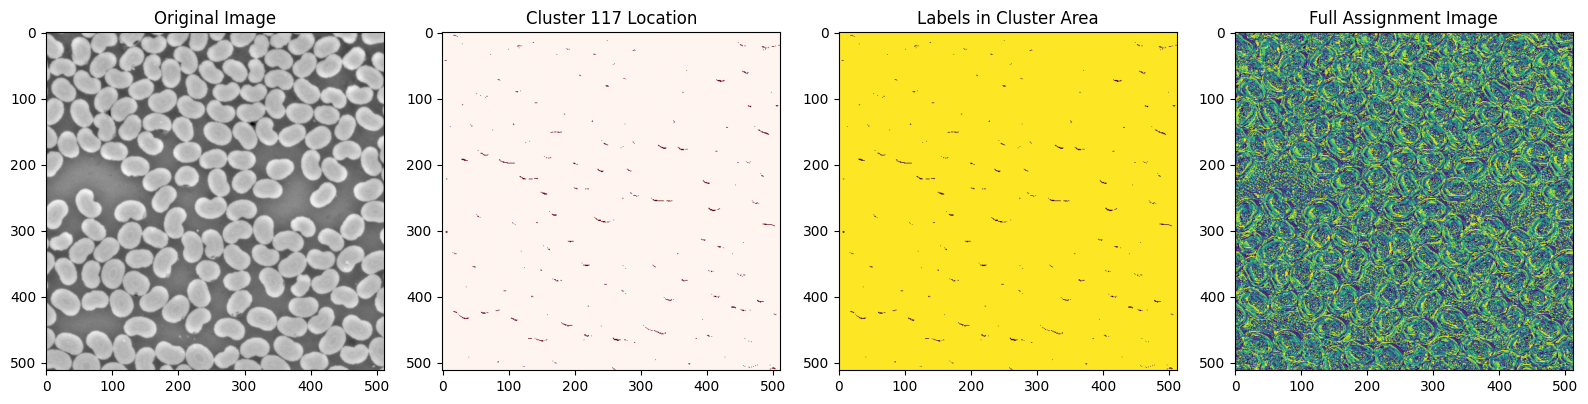

Cluster 117 contains:
  - 1078 pixels with label 0 (100.0%)
  - 0 pixels with label 127 (0.0%)
  - 0 pixels with label 255 (0.0%)
  → Cluster 117 gets Label 1


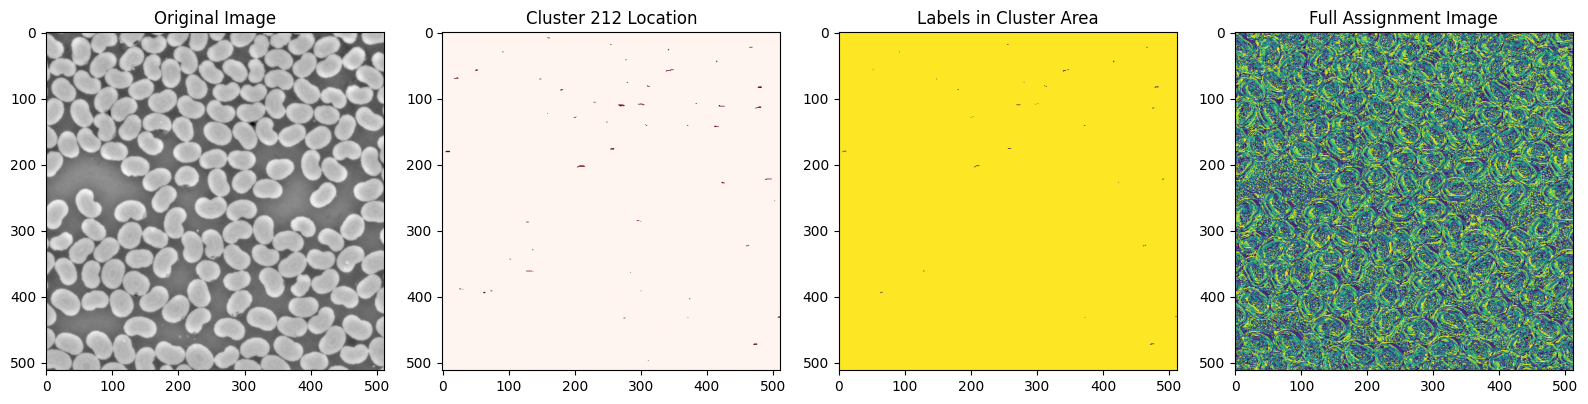

Cluster 212 contains:
  - 90 pixels with label 0 (30.2%)
  - 208 pixels with label 127 (69.8%)
  - 0 pixels with label 255 (0.0%)
  → Cluster 212 gets Label 2


In [36]:
import matplotlib.pyplot as plt

def visualize_cluster_analysis(cluster_id, assignment_image, label_image, original_image):
    """See exactly what's happening visually"""
    
    # Create a mask showing only this cluster
    cluster_mask = (assignment_image == cluster_id)
    
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Show original image
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    
    # Show where cluster appears
    cluster_overlay = np.zeros_like(original_image)
    cluster_overlay[cluster_mask] = 255
    axes[1].imshow(cluster_overlay, cmap='Reds')
    axes[1].set_title(f'Cluster {cluster_id} Location')
    
    # Show labels in that area  
    labels_overlay = np.copy(label_image)
    labels_overlay[~cluster_mask] = 128  # Gray out non-cluster areas
    axes[2].imshow(labels_overlay)
    axes[2].set_title('Labels in Cluster Area')
    
    # Show the assignment image
    axes[3].imshow(assignment_image, cmap='viridis')
    axes[3].set_title('Full Assignment Image')
    
    plt.tight_layout()
    plt.show()
    
    # Count and report
    labels_in_cluster = label_image[cluster_mask]
    counts = {
        0: (labels_in_cluster == 0).sum(),
        127: (labels_in_cluster == 127).sum(), 
        255: (labels_in_cluster == 255).sum()
    }
    
    print(f"Cluster {cluster_id} contains:")
    for label_val, count in counts.items():
        percentage = count / len(labels_in_cluster) * 100
        print(f"  - {count} pixels with label {label_val} ({percentage:.1f}%)")
    
    # Determine winner
    max_count = max(counts.values())
    winner_label_val = [k for k, v in counts.items() if v == max_count][0]
    winner_index = [0, 127, 255].index(winner_label_val) + 1
    
    print(f"  → Cluster {cluster_id} gets Label {winner_index}")
    return winner_index

# Use it
for cluster in [17, 27, 117, 212]:
    visualize_cluster_analysis(cluster, assignment_im, label_im, im)

In [37]:
def solve_with_dictionary_thinking():
    """Think of it like looking up answers in a dictionary"""
    
    # Create a "dictionary" mapping each cluster to its most common label
    cluster_to_label = {}
    
    print("Building cluster dictionary...")
    
    # Check a few example clusters first to understand the pattern
    example_clusters = [17, 27, 117, 212]
    
    for cluster_id in example_clusters:
        # "Look up" this cluster
        print(f"\nLooking up cluster {cluster_id}:")
        
        # Find all places this cluster appears
        is_this_cluster = (assignment_im == cluster_id)
        
        # What labels do those places have?
        label_values_there = label_im[is_this_cluster]
        
        print(f"  This cluster appears in {len(label_values_there)} pixels")
        print(f"  Those pixels have these label values: {np.unique(label_values_there)}")
        
        # Count each type
        label_counts = {}
        for label_val in [0, 127, 255]:
            count = (label_values_there == label_val).sum()
            label_counts[label_val] = count
            print(f"    {label_val}: {count} pixels")
        
        # Pick the winner
        most_common_label_val = max(label_counts, key=label_counts.get)
        final_label = {0: 1, 127: 2, 255: 3}[most_common_label_val]
        
        cluster_to_label[cluster_id] = final_label
        print(f"  → Cluster {cluster_id} = Label {final_label}")
    
    return [cluster_to_label[c] for c in [17, 27, 117, 212]]

answer = solve_with_dictionary_thinking()
print(f"\nAnswer: {answer}")

Building cluster dictionary...

Looking up cluster 17:
  This cluster appears in 880 pixels
  Those pixels have these label values: [127 255]
    0: 0 pixels
    127: 840 pixels
    255: 40 pixels
  → Cluster 17 = Label 2

Looking up cluster 27:
  This cluster appears in 462 pixels
  Those pixels have these label values: [127 255]
    0: 0 pixels
    127: 61 pixels
    255: 401 pixels
  → Cluster 27 = Label 3

Looking up cluster 117:
  This cluster appears in 1078 pixels
  Those pixels have these label values: [0]
    0: 1078 pixels
    127: 0 pixels
    255: 0 pixels
  → Cluster 117 = Label 1

Looking up cluster 212:
  This cluster appears in 298 pixels
  Those pixels have these label values: [  0 127]
    0: 90 pixels
    127: 208 pixels
    255: 0 pixels
  → Cluster 212 = Label 2

Answer: [2, 3, 1, 2]


In [38]:
def manual_approach():
    """What you'd do if you had to solve this with a magnifying glass"""
    
    answer = []
    
    for cluster_num in [17, 27, 117, 212]:
        print(f"\n🔍 Examining cluster {cluster_num}:")
        print("   Step 1: Find where this cluster appears in the assignment image")
        
        # Find coordinates where assignment_im has value cluster_num
        y_coords, x_coords = np.where(assignment_im == cluster_num)
        print(f"   Found {len(y_coords)} pixels with this cluster")
        
        print("   Step 2: Look at those exact spots in the label image")
        label_votes = []
        
        # Look at first few pixels as examples
        for i in range(min(5, len(y_coords))):
            y, x = y_coords[i], x_coords[i]
            label_here = label_im[y, x]
            label_votes.append(label_here)
            print(f"     Pixel ({y},{x}): cluster={assignment_im[y,x]}, label={label_here}")
        
        print("   Step 3: Count all votes")
        all_votes = label_im[y_coords, x_coords]
        
        vote_count_0 = (all_votes == 0).sum()
        vote_count_127 = (all_votes == 127).sum()  
        vote_count_255 = (all_votes == 255).sum()
        
        print(f"     Votes for label 0 (black): {vote_count_0}")
        print(f"     Votes for label 127 (grey): {vote_count_127}")
        print(f"     Votes for label 255 (white): {vote_count_255}")
        
        print("   Step 4: Pick the winner")
        votes = [vote_count_0, vote_count_127, vote_count_255]
        winner = votes.index(max(votes)) + 1
        
        print(f"   🏆 Cluster {cluster_num} → Label {winner}")
        answer.append(winner)
    
    return answer

final_answer = manual_approach()
print(f"\n📝 Final Answer: {final_answer}")


🔍 Examining cluster 17:
   Step 1: Find where this cluster appears in the assignment image
   Found 880 pixels with this cluster
   Step 2: Look at those exact spots in the label image
     Pixel (4,63): cluster=17, label=255
     Pixel (4,192): cluster=17, label=127
     Pixel (6,387): cluster=17, label=127
     Pixel (6,389): cluster=17, label=127
     Pixel (7,346): cluster=17, label=127
   Step 3: Count all votes
     Votes for label 0 (black): 0
     Votes for label 127 (grey): 840
     Votes for label 255 (white): 40
   Step 4: Pick the winner
   🏆 Cluster 17 → Label 2

🔍 Examining cluster 27:
   Step 1: Find where this cluster appears in the assignment image
   Found 462 pixels with this cluster
   Step 2: Look at those exact spots in the label image
     Pixel (4,440): cluster=27, label=127
     Pixel (4,442): cluster=27, label=127
     Pixel (4,443): cluster=27, label=127
     Pixel (4,444): cluster=27, label=127
     Pixel (5,445): cluster=27, label=127
   Step 3: Count all 